# Introducción

En el presente laboratorio se solicitó entrenar un *Character-level Languaje Model* basado en *Recurrent Neural Network* (RNN) sobre un conjunto de textos, que en este caso es el libro *War and Peace* del escritor ruso Leo Tolstoy, publicada en 1869.

El objetivo del laboratorio es usar el modelo generado para predecir y generar texto completamente nuevo en base del original, para su posterior análisis.

Dicho libro se encontrará en formato **.txt** con un peso de 3.3 MB, siguiendo la sugerencia de tener como mínimo un tamaño de 2 MB, para poder generar un modelo aceptable.

* Recurrent Neural Network (RNN): https://chunml.github.io/ChunML.github.io/project/Creating-Text-Generator-Using-Recurrent-Neural-Network/
* DataSet: https://cs.stanford.edu/people/karpathy/char-rnn/

## Índice
1. Instalación de Librerías
2. Procesamiento
3. Entrenamiento y Prueba
4. Generación de texto

## Ejecución

* Desde 0: Puntos 1-4
* Entrenar: Puntos 1, 2, **Entrenamiento** de 3, 4
* Generar texto: Puntos 1, 2 y 4

# 1. Instalación de Librerías

## Windows

Usando Anaconda Prompt se debe usar los siguientes comandos para importar la librería de Keras. Entrar en modo administrador a Anaconda Prompt e introducir los siguientes comandos.

```conda update conda ```
<br>```conda install keras ```

## Linux

En primer lugar actualizar el tensorflow medianter terminal.

```python3 -m pip install -U --user tensorflow```

Luego, ejecutar los siguientes comandos.

In [4]:
#!pip install cython --user
#!pip install --force-reinstall regex==2017.04.5
#!pip install pathlib --user
#!pip install msgpack --user
!pip install tensorflow-gpu --user
!pip install keras --user

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 307kB 5.9MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 15.5MB/s ta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Verificación

Pruebo la correcta importación de librerías.

In [1]:
import tensorflow as tf
hello = tf.constant("Hello, TF!")
sess = tf.Session()
print(sess.run(hello))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


b'Hello, TF!'


In [2]:
a = tf.constant(10)
b = tf.constant(32)
print(sess.run(a + b))

42


In [3]:
import keras

Using TensorFlow backend.


# 2. Procesamiento

## Definición de Variables

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.wrappers import TimeDistributed
import pickle

In [5]:
#Archivo de texto 
DATA_DIR = "./warpeace_input.txt" 
#Modificar BATCH_SIZE o HIDDEN_DIM en caso tengan problemas de memoria
BATCH_SIZE = 50 
HIDDEN_DIM = 250 #500
#Parametro para longitud de secuencia a analizar
SEQ_LENGTH = 50 
#Parametro para cargar un pesos previamente entrenados (checkpoint)
WEIGHTS = '' 

#Parametro para indicar cuantos caracteres generar en cada prueba
GENERATE_LENGTH = 500 
#Parametros para la red neuronal
LAYER_NUM = 2 
NB_EPOCH = 20

## Definición de Funciones

### Función A
(1) Carga de un archivo de texto, (2) Construcción de estructuras de entrada y salida de la red.

In [6]:
# method for preparing the training data
def load_data(data_dir, seq_length):
    #Carga del archivo
    data = open(data_dir, 'r').read()
    #Caracteres unicos
    chars = list(set(data))
    VOCAB_SIZE = len(chars)

    print('Data length: {} characters'.format(len(data)))
    print('Vocabulary size: {} characters'.format(VOCAB_SIZE))
    print(chars)
    
    #Indexacion de los caracteres
    ix_to_char = {ix:char for ix, char in enumerate(chars)}
    char_to_ix = {char:ix for ix, char in enumerate(chars)}
    
    #Estructuras de entrada y salida
    NUMBER_OF_SEQ = int(len(data)/seq_length)
    print('Number of sequences: {}'.format(NUMBER_OF_SEQ))
    X = np.zeros((NUMBER_OF_SEQ, seq_length, VOCAB_SIZE))
    y = np.zeros((NUMBER_OF_SEQ, seq_length, VOCAB_SIZE))
    
    for i in range(0, NUMBER_OF_SEQ):
        #LLenado de la estructura de entrada X
        X_sequence = data[i*seq_length:(i+1)*seq_length]
        X_sequence_ix = [char_to_ix[value] for value in X_sequence]
        #one-hot-vector (input)
        input_sequence = np.zeros((seq_length, VOCAB_SIZE))  
        #uso del diccionario para completar el one-hot-vector
        for j in range(seq_length):
            input_sequence[j][X_sequence_ix[j]] = 1.
            X[i] = input_sequence
            
        #Llenado de la estructura de salida y
        y_sequence = data[i*seq_length+1:(i+1)*seq_length+1]
        y_sequence_ix = [char_to_ix[value] for value in y_sequence]
        #one-hot-vector (output)
        target_sequence = np.zeros((seq_length, VOCAB_SIZE))
        #uso del diccionario para completar el one-hot-vector
        for j in range(seq_length):
            target_sequence[j][y_sequence_ix[j]] = 1.
            y[i] = target_sequence
            
    return X, y, VOCAB_SIZE, ix_to_char

### Función B
Generación de textos.

In [7]:
# method for generating text
def generate_text(model, length, vocab_size, ix_to_char):
    # starting with random character
    ix = [np.random.randint(vocab_size)]
    y_char = [ix_to_char[ix[-1]]]
    X = np.zeros((1, length, vocab_size))
    for i in range(length):
        # appending the last predicted character to sequence
        X[0, i, :][ix[-1]] = 1
        print(ix_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(ix_to_char[ix[-1]])
    return ('').join(y_char)

### Función C
Obtener el tamaño del vocabulario.

In [8]:
def vocab_size(data_dir):
    #Carga del archivo
    data = open(data_dir, 'r').read()
    #Caracteres unicos
    chars = list(set(data))
    return len(chars)

# 3. Entrenamiento y Prueba

## Creación de Diccionario

*** ADVERTENCIA: NO EJECUTAR ESTA SECCIÓN SI ES QUE YA EXISTEN CHECKPOINTS Y IX_TO_CHAR ***

Uso de la Función A: carga de los datos.

In [12]:
# Creating training data
X, y, VOCAB_SIZE, ix_to_char = load_data(DATA_DIR, SEQ_LENGTH)

Data length: 3196232 characters
Vocabulary size: 86 characters
['L', 'm', 'G', 'x', 'b', 'T', '9', '(', '8', 'R', 'M', 'n', ' ', 'N', 'a', 'v', ')', '!', 'g', 'H', 'K', 'l', 'c', 'k', 'r', 'X', '¤', 'q', '5', 'y', 'w', '*', 'A', ';', 'z', 'h', 'D', 'E', '»', 'u', '1', 'ï', 't', 'd', 'U', '6', '-', '¿', 'p', '3', 'O', 'Z', 'V', 'i', 'Q', '?', '.', 'P', 'J', 'W', 'o', '/', 'f', '7', '"', '=', '\n', '©', '0', ':', "'", 'I', ',', 'C', '\xa0', 'Y', 's', 'ª', 'e', 'j', '2', 'F', 'Ã', 'B', 'S', '4']
Number of sequences: 63924


Es importante guardar el diccionario `ix_to_char` en un archivo binario. Este debe ser cargado cada vez que se quiera retomar el entrenamiento o generar texto a partir de un *checkpoint*, debido a que el orden de los caracteres en el diccionario podría modificarse (no es un orden fijo).

***NO MODIFICAR ESTE PICKLE AL REINICIAR EL NOTEBOOK PARA PROBAR CHECKPOINTS***

In [13]:
#No modificar el pickle al reiniciar el cuaderno de trabajo para probar checkpoints previos
with open('ix_to_char.pickle', 'wb') as handle:
    pickle.dump(ix_to_char, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
print(ix_to_char)

{0: 'L', 1: 'm', 2: 'G', 3: 'x', 4: 'b', 5: 'T', 6: '9', 7: '(', 8: '8', 9: 'R', 10: 'M', 11: 'n', 12: ' ', 13: 'N', 14: 'a', 15: 'v', 16: ')', 17: '!', 18: 'g', 19: 'H', 20: 'K', 21: 'l', 22: 'c', 23: 'k', 24: 'r', 25: 'X', 26: '¤', 27: 'q', 28: '5', 29: 'y', 30: 'w', 31: '*', 32: 'A', 33: ';', 34: 'z', 35: 'h', 36: 'D', 37: 'E', 38: '»', 39: 'u', 40: '1', 41: 'ï', 42: 't', 43: 'd', 44: 'U', 45: '6', 46: '-', 47: '¿', 48: 'p', 49: '3', 50: 'O', 51: 'Z', 52: 'V', 53: 'i', 54: 'Q', 55: '?', 56: '.', 57: 'P', 58: 'J', 59: 'W', 60: 'o', 61: '/', 62: 'f', 63: '7', 64: '"', 65: '=', 66: '\n', 67: '©', 68: '0', 69: ':', 70: "'", 71: 'I', 72: ',', 73: 'C', 74: '\xa0', 75: 'Y', 76: 's', 77: 'ª', 78: 'e', 79: 'j', 80: '2', 81: 'F', 82: 'Ã', 83: 'B', 84: 'S', 85: '4'}


In [15]:
print(X.shape, y.shape, VOCAB_SIZE)

(63924, 50, 86) (63924, 50, 86) 86


## Entrenamiento

*** ADVERTENCIA: EJECUTAR DESDE ACÁ PARA ENTRENAR AL MODELO ***

### Creación de la RNN (LSTM)

In [29]:
#VOCAB_SIZE = vocab_size(DATA_DIR)
VOCAB_SIZE = 86

In [30]:
# Creating and compiling the Network
model = Sequential()

#Añadiendo las capas LSTM
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(LAYER_NUM - 1):
    model.add(LSTM(HIDDEN_DIM, return_sequences=True))
#Añadiendo la operacion de salida
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))

#"Compilando" = instanciando la RNN con su función de pérdida y optimización
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

In [18]:
# Generate some sample before training to know how bad it is!
generate_text(model, GENERATE_LENGTH, VOCAB_SIZE, ix_to_char)

?uyX0r0;;;;kkkkkkkkªªkkªkªRkRkRXXkiiiooï....GGGGGGYccccppppppppppP      )    ïïOOOOO8888(((gg(((gg(((gg(((gg¿¿¿¿¿¿¿ÃÃÃÃÃÃÃpppppppppppp     )     OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOcc

'?uyX0r0;;;;kkkkkkkkªªkkªkªRkRkRXXkiiiooï....GGGGGGYccccppppppppppP      )    ïïOOOOO8888(((gg(((gg(((gg(((gg¿¿¿¿¿¿¿ÃÃÃÃÃÃÃpppppppppppp     )     OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccccccpppppp)))         OOOOOccc'

### Generación de Modelo

Se cargan los pesos (y el diccionario de los one-hot-vectors) en caso haya habido un entrenamiento previo. WEIGHTS debe tener el valor del nombre del archivo de "checkpoint" guardado.

Por ejemplo: ```WEIGHTS = "checkpoint_layer_2_hidden_250_epoch_60.hdf5"```

In [31]:
#Se cargan los pesos de un entrenamiento previo (si se desea restaurar una ejecucion)
#Se calcula el numero de epocas en base al nombre del archivo
#Se carga el diccionario de caracteres (one-hot-vectors) para la generacion

WEIGHTS = "checkpoint_layer_2_hidden_250_epoch_10.hdf5" 

if not WEIGHTS == '':
    model.load_weights(WEIGHTS)
    nb_epoch = int(WEIGHTS[WEIGHTS.rfind('_') + 1:WEIGHTS.find('.')])
    with open('ix_to_char.pickle', 'rb') as handle:
        ix_to_char = pickle.load(handle)
else:
    #Si se va a empezar de 0:
    nb_epoch = 0

In [32]:
# Training if there is no trained weights specified

#Esta es la iteración importante
#Pueden cambiar la condición para que termine en un determinado numero de epochs.
while True:
    print('\n\nEpoch: {}\n'.format(nb_epoch))
    #Ajuste del modelo, y entrenamiento de 1 epoca
    model.fit(X, y, batch_size=BATCH_SIZE, verbose=1, epochs=1)
    nb_epoch += 1
    #Generacion de un texto al final de la epoca
    generate_text(model, GENERATE_LENGTH, VOCAB_SIZE, ix_to_char)
    #Pueden modificar esto para tener más checkpoints
    if nb_epoch % 10 == 0:
        model.save_weights('checkpoint_layer_{}_hidden_{}_epoch_{}.hdf5'.format(LAYER_NUM, HIDDEN_DIM, nb_epoch))
    if nb_epoch == 80:
        break



Epoch: 10

Epoch 1/1
63924/63924 [==============================] - 499s 8ms/step - loss: 1.1963
y the same time the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the

Epoch: 11

Epoch 1/1
63924/63924 [==============================] - 512s 8ms/step - loss: 1.1852
f the streets and the same time and the same time he was always strong and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and strength and streng

"I don't know what you would not be all the same thing. I won't go to the countess' door was a man who was not at all and did not like to see him and the same thing is the only thing of the countess and the count with a smile of destroy the country house on the strength of the contrary, the count was a man who was not at all and did not like to 

Epoch: 37

Epoch 1/1
63924/63924 [==============================] - 470s 7ms/step - loss: 1.0547
ing the street was standing by the stalls and the soldiers who were sitting and shouting and shouting and shook his head and said to him and said to him.

"What do you think of the day of the things and the state of things and the state of this interests of the country and the soldiers who were sitting on the staff of the commander in chief and the same time the soldiers who were sitting in the same way the soldiers who were sitting and shouting and shouting and shouting and shook his head and s

Epoch: 38

Epoch 1/1
63924/63924 [==================

me to the commander-in-chief. "If you want to come out at the countess' relations with the princess and the count to remain in the morning and the count and his wife who had been sent to the count and had to be of the conversation with the same thing as he had been an order to remain with him to see him and the count was as if she had not the commander of the staff of the commander of the room with a smile that he would be able to remember the countess and the count to her father and mother, and

Epoch: 64

Epoch 1/1
63924/63924 [==============================] - 456s 7ms/step - loss: 1.0074
; but he did not see the countess was so delighted to see him and the same as the same thing and the same as the Emperor and the countess was so fasting and seeming not to be a passionate and ascending the princesses, and the count was at the same time and did not see him and did not answer the conversation and was standing by the same way that she was not at all asked: the old prince had been prep

# 4. Generación de texto

Si instancian el modelo y sus parametros (ejecutando algunas celdas preliminares), y tienen los 2 archivos requeridos (.pickle y .hdf5) pueden generar el texto.
Si usted va a cargar defrente un *checkpoint*, ejecutar los siguientes 2 módulos.

In [18]:
#VOCAB_SIZE = vocab_size(DATA_DIR)
VOCAB_SIZE = 86

In [19]:
# Creating and compiling the Network
model = Sequential()

#Añadiendo las capas LSTM
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(LAYER_NUM - 1):
    model.add(LSTM(HIDDEN_DIM, return_sequences=True))
#Añadiendo la operacion de salida
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))

#"Compilando" = instanciando la RNN con su función de pérdida y optimización
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

Generar texto dependiendo del WEIGHTS.

In [20]:
#Cuidar de no reemplazar el pickle original
WEIGHTS = 'checkpoint_layer_2_hidden_250_epoch_80.hdf5'
nb_epoch = int(WEIGHTS[WEIGHTS.rfind('_') + 1:WEIGHTS.find('.')])
# Loading the trained weights
model.load_weights(WEIGHTS)
with open('ix_to_char.pickle', 'rb') as handle:
    ix_to_char = pickle.load(handle)
generate_text(model, GENERATE_LENGTH, VOCAB_SIZE, ix_to_char)
print('\n\n')

xpression of her father's withered from the time that he would be a series of virtue to him, and the sound of the commander-in-chief's soul, unexpectedly and that the commander-in-chief was struck by the sound of the commander-in-chief's significant look at the first moment the sounds of a box and the sound of the commander-in-chief's significant look at the first moment the sounds of a box and the sound of the commander-in-chief's significant look at the first moment the sounds of a box and the




In [21]:
nb_epoch

80

# Análisis

Abro el archivo de entrenamiento. Leo línea por línea del entrenamiento. Guardo en una lista el texto generado por cada entrenamiento

In [157]:
epoch=open("Entrenamiento.txt","r")

import collections as co
import re
linEpoch = epoch.readlines()
n=0
for i in linEpoch:
    if "Epoch:" in i:
        linEpoch.pop(n+1)
        linEpoch.pop(n+1)
        linEpoch.pop(n+1)
    n = n + 1

In [163]:
linEpochClean = []
for i in linEpoch:
    x = re.sub(r"[^a-zA-Z0-9 -]"," ",i)
    if x != " ":
        linEpochClean.append(x)

linEpochReady = []
aux = []
for i in linEpochClean:
    if "Epoch " in i:
        linEpochReady.append("".join(aux))
        aux = []
    else:
        aux.append(i)
linEpochReady.append("".join(aux))
linEpochReady.pop(0)

n = 0

for linea in linEpochReady:
    if linea == '':
        linEpochReady.pop(n)
    n=n+1
print('Epochs procesados:',len(linEpochReady))

Epochs procesados: 80


Abro el archivo del dataset. Genero un diccionario a partir de este.

In [159]:
data = open("warpeace_input.txt","r")

linDataset = []
linDataset = data.readlines()
linDatasetClean = []

for i in linDataset:
    x = re.sub(r"[^a-zA-Z0-9 -]"," ",i)
    linDatasetClean.append(x)
    
#Creacion de diccionario del dataset
diccDataset = co.Counter()
for linea in linDatasetClean:
    tokens = linea.split()
    diccDataset.update(tokens)
    
print('10 tokens mas comunes:',diccDataset.most_common(10))        
print('Numero de tokens:',sum(diccDataset.values()))
print('Tamaño del vocabulario:',len(diccDataset))

10 tokens mas comunes: [('the', 31638), ('and', 20995), ('to', 16396), ('of', 14813), ('a', 10016), ('in', 8210), ('he', 8070), ('that', 7695), ('his', 7661), ('was', 7311)]
Numero de tokens: 568202
Tamaño del vocabulario: 21485


Comparo el diccionario generado del dataset con respecto a diccionario de cada epoch procesado. Guardo el número de palabras del diccionario de *epoch*, como también el número de palabras presentes en el diccionario del *epoch* que no existen en el dataset.

In [165]:
numPal = [] #Numero de palabras en el diccionario de epoch
numDif = [] #Numero de palabras presentes en epoch que no existen en el dataset
n = 1
for linea in linEpochReady:
    lin = linea.split()    
    lin.pop()
    lin.pop(0)
    c = co.Counter()
    c.update(lin)
    print('Epoch',n,':')
    print('Numero de palabras en el diccionario de epoch:',len(c))
    palabras = []
    for palabra in c:
        if palabra in diccDataset:
            continue
        else:   
            palabras.append(palabra)
    print("Palabras presentes en echo que no existen en el dataset: ",palabras)
    numPal.append(len(c))
    numDif.append(len(palabras))
    n = n+1

Epoch 1 :
Numero de palabras en el diccionario de epoch: 6
Palabras presentes en echo que no existen en el dataset:  []
Epoch 2 :
Numero de palabras en el diccionario de epoch: 4
Palabras presentes en echo que no existen en el dataset:  []
Epoch 3 :
Numero de palabras en el diccionario de epoch: 9
Palabras presentes en echo que no existen en el dataset:  []
Epoch 4 :
Numero de palabras en el diccionario de epoch: 3
Palabras presentes en echo que no existen en el dataset:  []
Epoch 5 :
Numero de palabras en el diccionario de epoch: 16
Palabras presentes en echo que no existen en el dataset:  []
Epoch 6 :
Numero de palabras en el diccionario de epoch: 8
Palabras presentes en echo que no existen en el dataset:  []
Epoch 7 :
Numero de palabras en el diccionario de epoch: 9
Palabras presentes en echo que no existen en el dataset:  []
Epoch 8 :
Numero de palabras en el diccionario de epoch: 4
Palabras presentes en echo que no existen en el dataset:  []
Epoch 9 :
Numero de palabras en el dicc

Genero gráficos para poder visualizar los números calculados anteriormente con respecto a la comparación del dataset y cada *epoch*.

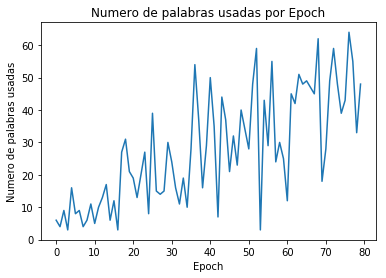

Epoch: 1  Número de palabras usadas:  6
Epoch: 2  Número de palabras usadas:  4
Epoch: 3  Número de palabras usadas:  9
Epoch: 4  Número de palabras usadas:  3
Epoch: 5  Número de palabras usadas:  16
Epoch: 6  Número de palabras usadas:  8
Epoch: 7  Número de palabras usadas:  9
Epoch: 8  Número de palabras usadas:  4
Epoch: 9  Número de palabras usadas:  6
Epoch: 10  Número de palabras usadas:  11
Epoch: 11  Número de palabras usadas:  5
Epoch: 12  Número de palabras usadas:  10
Epoch: 13  Número de palabras usadas:  13
Epoch: 14  Número de palabras usadas:  17
Epoch: 15  Número de palabras usadas:  6
Epoch: 16  Número de palabras usadas:  12
Epoch: 17  Número de palabras usadas:  3
Epoch: 18  Número de palabras usadas:  27
Epoch: 19  Número de palabras usadas:  31
Epoch: 20  Número de palabras usadas:  21
Epoch: 21  Número de palabras usadas:  19
Epoch: 22  Número de palabras usadas:  13
Epoch: 23  Número de palabras usadas:  20
Epoch: 24  Número de palabras usadas:  27
Epoch: 25  N

In [166]:
import matplotlib.pyplot as plt
y=numPal
plt.plot(y)
plt.xlabel('Epoch')
plt.ylabel('Numero de palabras usadas')
plt.title('Numero de palabras usadas por Epoch')
plt.show()
n=1
for i in numPal:
    print('Epoch:',n," Número de palabras usadas: ",i)
    n=n+1

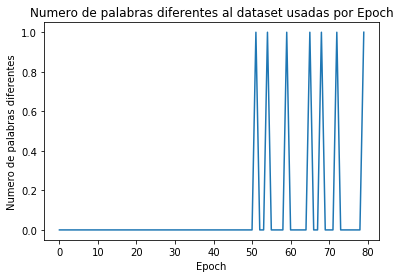

Epoch: 1 ) Numero de palabras diferentes:  0
Epoch: 2 ) Numero de palabras diferentes:  0
Epoch: 3 ) Numero de palabras diferentes:  0
Epoch: 4 ) Numero de palabras diferentes:  0
Epoch: 5 ) Numero de palabras diferentes:  0
Epoch: 6 ) Numero de palabras diferentes:  0
Epoch: 7 ) Numero de palabras diferentes:  0
Epoch: 8 ) Numero de palabras diferentes:  0
Epoch: 9 ) Numero de palabras diferentes:  0
Epoch: 10 ) Numero de palabras diferentes:  0
Epoch: 11 ) Numero de palabras diferentes:  0
Epoch: 12 ) Numero de palabras diferentes:  0
Epoch: 13 ) Numero de palabras diferentes:  0
Epoch: 14 ) Numero de palabras diferentes:  0
Epoch: 15 ) Numero de palabras diferentes:  0
Epoch: 16 ) Numero de palabras diferentes:  0
Epoch: 17 ) Numero de palabras diferentes:  0
Epoch: 18 ) Numero de palabras diferentes:  0
Epoch: 19 ) Numero de palabras diferentes:  0
Epoch: 20 ) Numero de palabras diferentes:  0
Epoch: 21 ) Numero de palabras diferentes:  0
Epoch: 22 ) Numero de palabras diferentes: 

In [167]:
import matplotlib.pyplot as plt
y=numDif
plt.plot(y)
plt.xlabel('Epoch')
plt.ylabel('Numero de palabras diferentes')
plt.title('Numero de palabras diferentes al dataset usadas por Epoch')
plt.show()
n=1
for i in numDif:
    print('Epoch:',n,") Numero de palabras diferentes: ",i)
    n=n+1